In [1]:
import requests
import os
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Downloading and Unzipping Dataset

In [3]:
url = "http://files.grouplens.org/datasets/movielens/ml-1m.zip"
download_path = "/content/ml-1m.zip"

response = requests.get(url, stream=True)
with open(download_path, "wb") as file:
    for chunk in response.iter_content(chunk_size=8192):
        file.write(chunk)

print("Dataset downloaded successfully.")

Dataset downloaded successfully.


In [4]:
import zipfile

extract_path = "/content/ml-1m"

os.makedirs(extract_path, exist_ok=True)

# Unzip the downloaded file
with zipfile.ZipFile(download_path, "r") as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")

Dataset extracted successfully.


##Main dataframe for Dataset

In [5]:
ratings_file = os.path.join(extract_path, "ml-1m", "ratings.dat")
movies_file = os.path.join(extract_path, "ml-1m", "movies.dat")

ratings_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
df = pd.read_csv(ratings_file, sep='::', engine='python', header=None, names=ratings_columns)

# movies_columns = ['MovieID', 'Title', 'Genres']
# movies_data = pd.read_csv(movies_file, sep='::', engine='python', header=None, names=movies_columns)

# Display sample data
print("Sample Ratings Data:")
print(df.head())

# print("\nSample Movies Data:")
# print(movies_data.head())


Sample Ratings Data:
   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 4 columns):
 #   Column     Non-Null Count    Dtype
---  ------     --------------    -----
 0   UserID     1000209 non-null  int64
 1   MovieID    1000209 non-null  int64
 2   Rating     1000209 non-null  int64
 3   Timestamp  1000209 non-null  int64
dtypes: int64(4)
memory usage: 30.5 MB


In [ ]:
df.UserID.nunique()

6040

In [ ]:
df.MovieID.nunique()

3706

In [ ]:
df.Rating.value_counts()

4    348971
3    261197
5    226310
2    107557
1     56174
Name: Rating, dtype: int64

In [ ]:
df.shape

(1000209, 4)

## Defining Dataset Wrapper Class


In [6]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long)
        }

##Neural Collaborative Filtering Model Architecture

In [7]:
class RecSysModel(nn.Module):
    def __init__(self,n_users,n_movies):
        super().__init__()
        self.user_embed = nn.Embedding(n_users,128)
        self.movie_embed = nn.Embedding(n_movies,128)
        self.fc1 = nn.Linear(256,80)
        self.fc2 = nn.Linear(80,160)
        self.fc3 = nn.Linear(160,80)
        self.fc4 = nn.Linear(80,1)
        self.activation_func = nn.ReLU()

    def forward(self, users, movies, ratings=None):
        user_embeds = self.user_embed(users)
        movie_embeds = self.movie_embed(movies)
        output = torch.cat([user_embeds, movie_embeds], dim=1)
        output = self.activation_func(self.fc1(output))
        output = self.activation_func(self.fc2(output))
        output = self.activation_func(self.fc3(output))
        output = self.fc4(output)
        return output

import torch.nn.functional as F

# class RecSysModel(nn.Module):
#     def __init__(self, n_users, n_movies, embedding_dim, hidden_layers, hidden_units, activation_func):
#         super().__init__()
#         self.user_embed = nn.Embedding(n_users, embedding_dim)
#         self.movie_embed = nn.Embedding(n_movies, embedding_dim)

#         self.fc_layers = nn.ModuleList()  # List to hold fully connected layers

#         prev_units = 2 * embedding_dim  # Initial input size for fully connected layers

#         # Add hidden layers with batch normalization and activation functions
#         for units in hidden_units:
#             self.fc_layers.append(nn.Linear(prev_units, units))
#             self.fc_layers.append(nn.BatchNorm1d(units))  # Batch normalization
#             self.fc_layers.append(activation_func)
#             prev_units = units

#         self.out = nn.Linear(prev_units, 1)

#     def forward(self, users, movies, ratings=None):
#         user_embeds = self.user_embed(users)
#         movie_embeds = self.movie_embed(movies)
#         output = torch.cat([user_embeds, movie_embeds], dim=1)

#         # Pass through fully connected layers
#         for layer in self.fc_layers:
#             output = layer(output)

#         output = self.out(output)
#         return output


## Encode labels and make Train and Test Datasets

In [8]:
# encoding ids to start from 0 to remove index out of bounds with embedding
lbl_user = preprocessing.LabelEncoder()
lbl_movie =preprocessing.LabelEncoder()
df.UserID = lbl_user.fit_transform(df.UserID.values)
df.MovieID = lbl_movie.fit_transform(df.MovieID.values)


df_train, df_test = model_selection.train_test_split(df, test_size = 0.2, random_state = 42, stratify=df.Rating.values)

train_dataset = MovieDataset(users=df_train.UserID.values, movies=df_train.MovieID.values, ratings=df_train.Rating.values )
test_dataset = MovieDataset(users=df_test.UserID.values, movies=df_test.MovieID.values, ratings=df_test.Rating.values )

In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size=1024, shuffle = True)
test_loader = DataLoader(dataset = test_dataset, batch_size=1024, shuffle = True)


## Using Optuna for hyperparameter tuning
Finding the perfect architecture of the ncf model using optuna

In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 9.3 MB/s eta 0:00:00


###Utilility functions for hyperparameter tunning

In [ ]:
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from collections import defaultdict

loss_func = nn.MSELoss()

# Function to calculate validation loss
def calculate_validation_loss(model, data_loader, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_data in data_loader:
            output = model(batch_data["users"].to(device), batch_data["movies"].to(device))
            rating = batch_data["ratings"].unsqueeze(-1).to(torch.float32).to(device)
            loss = loss_func(output, rating)
            total_loss += loss.sum().item()
    avg_loss = total_loss / len(data_loader.dataset)
    return avg_loss

# Function to calculate precision and recall at k
def calculate_precision_recall_at_k(model, data_loader, device, k, threshold):
    user_est_true = defaultdict(list)
    with torch.no_grad():
        model.eval()
        for batch_data in data_loader:
            users = batch_data["users"]
            movies = batch_data["movies"]
            ratings = batch_data["ratings"]

            model_output = model(users.to(device), movies.to(device))
            for j in range(len(users)):
                user_id = users[j].item()
                movie_id = movies[j].item()
                pred_rating = model_output[j][0].item()
                true_rating = ratings[j].item()

                user_est_true[user_id].append((pred_rating, true_rating))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_n_rec_K = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])
        precisions[uid] = n_rel_and_n_rec_K / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_n_rec_K / n_rel if n_rel != 0 else 0

    precision_at_k = sum(prec for prec in precisions.values()) / len(precisions)
    recall_at_k = sum(prec for prec in recalls.values()) / len(recalls)
    return precision_at_k, recall_at_k



##Objective function to optimize for hyperparameter tunning

In [ ]:
from tqdm import tqdm
def objective(trial):
    # Define hyperparameters to tune
    embedding_dim = trial.suggest_int("embedding_dim", 16, 256)
    hidden_layers = trial.suggest_int("hidden_layers", 1, 8)
    hidden_units = [trial.suggest_int(f"hidden_units_layer{i}", 16, 256) for i in range(hidden_layers)]
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1)
    activation_func = nn.ReLU()

    # Create RecSysModel with suggested hyperparameters
    model = RecSysModel(
        n_users=len(lbl_user.classes_),
        n_movies=len(lbl_movie.classes_),
        embedding_dim=embedding_dim,
        hidden_layers=hidden_layers,
        hidden_units=hidden_units,
        activation_func=activation_func
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss_func = nn.MSELoss()

    # Training loop with early stopping
    epochs = 1
    # patience = 1
    best_val_loss = float('inf')
    early_stopping_counter = 0

    for epoch_i in range(epochs):
        # if early_stopping_counter >= patience:
        #     print("Early stopping triggered. Stopping training.")
        #     break

        total_loss = 0
        model.train()
        for i, train_data in tqdm(enumerate(train_loader)):
            output = model(train_data["users"].to(device), train_data["movies"].to(device))
            rating = train_data["ratings"].unsqueeze(-1).to(torch.float32).to(device)
            loss = loss_func(output, rating)
            total_loss = total_loss + loss.sum().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # # Calculate validation loss
        # val_loss = calculate_validation_loss(model, test_loader, device)


        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     early_stopping_counter = 0
        # else:
        #     early_stopping_counter += 1

    # Calculate precision and recall at k
    k = 20
    threshold = 4
    precision_at_k, recall_at_k = calculate_precision_recall_at_k(model, test_loader, device, k, threshold)

    f1_score = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) != 0 else 0
    val_loss = calculate_validation_loss(model, test_loader, device)

    print(f"Trial: {trial.number} Val_loss: {val_loss} f1_score: {f1_score} Params: {trial.params}")

    return -f1_score  # Negative sign because Optuna tries to minimize the objective

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
# print("Value: ", trial.value)
print("Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")


[I 2023-08-16 05:07:28,714] A new study created in memory with name: no-name-3bfcc970-e99e-4a00-9c9c-b4693b222a12
25006it [01:53, 220.20it/s]
[I 2023-08-16 05:09:49,118] Trial 0 finished with value: -0.3602855232071474 and parameters: {'embedding_dim': 159, 'hidden_layers': 6, 'hidden_units_layer0': 238, 'hidden_units_layer1': 70, 'hidden_units_layer2': 73, 'hidden_units_layer3': 29, 'hidden_units_layer4': 198, 'hidden_units_layer5': 32, 'learning_rate': 0.017948288649173052}. Best is trial 0 with value: -0.3602855232071474.


Trial: 0 Val_loss: 0.026255138730746204 f1_score: 0.3602855232071474 Params: {'embedding_dim': 159, 'hidden_layers': 6, 'hidden_units_layer0': 238, 'hidden_units_layer1': 70, 'hidden_units_layer2': 73, 'hidden_units_layer3': 29, 'hidden_units_layer4': 198, 'hidden_units_layer5': 32, 'learning_rate': 0.017948288649173052}


25006it [01:13, 342.49it/s]
[I 2023-08-16 05:11:22,046] Trial 1 finished with value: -0.5752949677918482 and parameters: {'embedding_dim': 72, 'hidden_layers': 2, 'hidden_units_layer0': 106, 'hidden_units_layer1': 75, 'learning_rate': 0.018151780393850854}. Best is trial 1 with value: -0.5752949677918482.


Trial: 1 Val_loss: 0.02597434462934947 f1_score: 0.5752949677918482 Params: {'embedding_dim': 72, 'hidden_layers': 2, 'hidden_units_layer0': 106, 'hidden_units_layer1': 75, 'learning_rate': 0.018151780393850854}


25006it [01:59, 208.46it/s]
[I 2023-08-16 05:13:49,630] Trial 2 finished with value: -0.2633737155651034 and parameters: {'embedding_dim': 252, 'hidden_layers': 7, 'hidden_units_layer0': 143, 'hidden_units_layer1': 82, 'hidden_units_layer2': 143, 'hidden_units_layer3': 104, 'hidden_units_layer4': 144, 'hidden_units_layer5': 73, 'hidden_units_layer6': 191, 'learning_rate': 0.02283111432634825}. Best is trial 1 with value: -0.5752949677918482.


Trial: 2 Val_loss: 0.026871761101993036 f1_score: 0.2633737155651034 Params: {'embedding_dim': 252, 'hidden_layers': 7, 'hidden_units_layer0': 143, 'hidden_units_layer1': 82, 'hidden_units_layer2': 143, 'hidden_units_layer3': 104, 'hidden_units_layer4': 144, 'hidden_units_layer5': 73, 'hidden_units_layer6': 191, 'learning_rate': 0.02283111432634825}


25006it [01:12, 346.74it/s]
[I 2023-08-16 05:15:21,783] Trial 3 finished with value: -0.4861312779938367 and parameters: {'embedding_dim': 100, 'hidden_layers': 2, 'hidden_units_layer0': 20, 'hidden_units_layer1': 55, 'learning_rate': 0.07940344747042455}. Best is trial 1 with value: -0.5752949677918482.


Trial: 3 Val_loss: 0.02609639943970164 f1_score: 0.4861312779938367 Params: {'embedding_dim': 100, 'hidden_layers': 2, 'hidden_units_layer0': 20, 'hidden_units_layer1': 55, 'learning_rate': 0.07940344747042455}


25006it [01:49, 229.15it/s]
[I 2023-08-16 05:17:36,393] Trial 4 finished with value: -0.34634821345956224 and parameters: {'embedding_dim': 53, 'hidden_layers': 6, 'hidden_units_layer0': 91, 'hidden_units_layer1': 49, 'hidden_units_layer2': 238, 'hidden_units_layer3': 41, 'hidden_units_layer4': 106, 'hidden_units_layer5': 120, 'learning_rate': 0.05128252412817984}. Best is trial 1 with value: -0.5752949677918482.


Trial: 4 Val_loss: 0.02713482991951326 f1_score: 0.34634821345956224 Params: {'embedding_dim': 53, 'hidden_layers': 6, 'hidden_units_layer0': 91, 'hidden_units_layer1': 49, 'hidden_units_layer2': 238, 'hidden_units_layer3': 41, 'hidden_units_layer4': 106, 'hidden_units_layer5': 120, 'learning_rate': 0.05128252412817984}


25006it [01:37, 257.74it/s]
[I 2023-08-16 05:19:35,381] Trial 5 finished with value: -0.4315787395763563 and parameters: {'embedding_dim': 56, 'hidden_layers': 3, 'hidden_units_layer0': 131, 'hidden_units_layer1': 148, 'hidden_units_layer2': 237, 'learning_rate': 0.08525868125624485}. Best is trial 1 with value: -0.5752949677918482.


Trial: 5 Val_loss: 0.026888783183608995 f1_score: 0.4315787395763563 Params: {'embedding_dim': 56, 'hidden_layers': 3, 'hidden_units_layer0': 131, 'hidden_units_layer1': 148, 'hidden_units_layer2': 237, 'learning_rate': 0.08525868125624485}


25006it [01:25, 293.81it/s]
[I 2023-08-16 05:21:23,716] Trial 6 finished with value: -0.4000402206338678 and parameters: {'embedding_dim': 183, 'hidden_layers': 3, 'hidden_units_layer0': 62, 'hidden_units_layer1': 212, 'hidden_units_layer2': 109, 'learning_rate': 0.013195036925940472}. Best is trial 1 with value: -0.5752949677918482.


Trial: 6 Val_loss: 0.02611597217236167 f1_score: 0.4000402206338678 Params: {'embedding_dim': 183, 'hidden_layers': 3, 'hidden_units_layer0': 62, 'hidden_units_layer1': 212, 'hidden_units_layer2': 109, 'learning_rate': 0.013195036925940472}


25006it [01:34, 264.50it/s]
[I 2023-08-16 05:23:23,614] Trial 7 finished with value: -0.5120382044775187 and parameters: {'embedding_dim': 144, 'hidden_layers': 4, 'hidden_units_layer0': 254, 'hidden_units_layer1': 125, 'hidden_units_layer2': 97, 'hidden_units_layer3': 72, 'learning_rate': 0.028050668001852644}. Best is trial 1 with value: -0.5752949677918482.


Trial: 7 Val_loss: 0.025683826708479948 f1_score: 0.5120382044775187 Params: {'embedding_dim': 144, 'hidden_layers': 4, 'hidden_units_layer0': 254, 'hidden_units_layer1': 125, 'hidden_units_layer2': 97, 'hidden_units_layer3': 72, 'learning_rate': 0.028050668001852644}


25006it [02:10, 192.13it/s]
[I 2023-08-16 05:26:02,956] Trial 8 finished with value: -0.45494741360141266 and parameters: {'embedding_dim': 48, 'hidden_layers': 8, 'hidden_units_layer0': 100, 'hidden_units_layer1': 190, 'hidden_units_layer2': 159, 'hidden_units_layer3': 141, 'hidden_units_layer4': 123, 'hidden_units_layer5': 75, 'hidden_units_layer6': 57, 'hidden_units_layer7': 79, 'learning_rate': 0.07365611564397052}. Best is trial 1 with value: -0.5752949677918482.


Trial: 8 Val_loss: 0.026139901958460277 f1_score: 0.45494741360141266 Params: {'embedding_dim': 48, 'hidden_layers': 8, 'hidden_units_layer0': 100, 'hidden_units_layer1': 190, 'hidden_units_layer2': 159, 'hidden_units_layer3': 141, 'hidden_units_layer4': 123, 'hidden_units_layer5': 75, 'hidden_units_layer6': 57, 'hidden_units_layer7': 79, 'learning_rate': 0.07365611564397052}


25006it [01:48, 229.90it/s]
[I 2023-08-16 05:28:16,984] Trial 9 finished with value: -0.4646852747058133 and parameters: {'embedding_dim': 186, 'hidden_layers': 6, 'hidden_units_layer0': 44, 'hidden_units_layer1': 72, 'hidden_units_layer2': 213, 'hidden_units_layer3': 78, 'hidden_units_layer4': 94, 'hidden_units_layer5': 172, 'learning_rate': 0.05699453148639979}. Best is trial 1 with value: -0.5752949677918482.


Trial: 9 Val_loss: 0.02591485625865324 f1_score: 0.4646852747058133 Params: {'embedding_dim': 186, 'hidden_layers': 6, 'hidden_units_layer0': 44, 'hidden_units_layer1': 72, 'hidden_units_layer2': 213, 'hidden_units_layer3': 78, 'hidden_units_layer4': 94, 'hidden_units_layer5': 172, 'learning_rate': 0.05699453148639979}


25006it [01:02, 397.55it/s]
[I 2023-08-16 05:29:40,068] Trial 10 finished with value: -0.35442862956271715 and parameters: {'embedding_dim': 104, 'hidden_layers': 1, 'hidden_units_layer0': 198, 'learning_rate': 2.6170844545828076e-05}. Best is trial 1 with value: -0.5752949677918482.


Trial: 10 Val_loss: 0.033663205604967224 f1_score: 0.35442862956271715 Params: {'embedding_dim': 104, 'hidden_layers': 1, 'hidden_units_layer0': 198, 'learning_rate': 2.6170844545828076e-05}


25006it [01:28, 281.45it/s]
[I 2023-08-16 05:31:31,846] Trial 11 finished with value: -0.4220979878792698 and parameters: {'embedding_dim': 116, 'hidden_layers': 4, 'hidden_units_layer0': 174, 'hidden_units_layer1': 126, 'hidden_units_layer2': 21, 'hidden_units_layer3': 241, 'learning_rate': 0.03309576520232218}. Best is trial 1 with value: -0.5752949677918482.


Trial: 11 Val_loss: 0.026038940134713605 f1_score: 0.4220979878792698 Params: {'embedding_dim': 116, 'hidden_layers': 4, 'hidden_units_layer0': 174, 'hidden_units_layer1': 126, 'hidden_units_layer2': 21, 'hidden_units_layer3': 241, 'learning_rate': 0.03309576520232218}


25006it [01:03, 395.11it/s]
[I 2023-08-16 05:32:54,233] Trial 12 finished with value: -0.5444808496309788 and parameters: {'embedding_dim': 20, 'hidden_layers': 1, 'hidden_units_layer0': 255, 'learning_rate': 0.03544900154211755}. Best is trial 1 with value: -0.5752949677918482.


Trial: 12 Val_loss: 0.026155328291691354 f1_score: 0.5444808496309788 Params: {'embedding_dim': 20, 'hidden_layers': 1, 'hidden_units_layer0': 255, 'learning_rate': 0.03544900154211755}


25006it [01:02, 400.17it/s]
[I 2023-08-16 05:34:16,398] Trial 13 finished with value: -0.34322361857367933 and parameters: {'embedding_dim': 20, 'hidden_layers': 1, 'hidden_units_layer0': 198, 'learning_rate': 0.0474829314737535}. Best is trial 1 with value: -0.5752949677918482.


Trial: 13 Val_loss: 0.027594565559492603 f1_score: 0.34322361857367933 Params: {'embedding_dim': 20, 'hidden_layers': 1, 'hidden_units_layer0': 198, 'learning_rate': 0.0474829314737535}


25006it [01:10, 354.79it/s]
[I 2023-08-16 05:35:49,434] Trial 14 finished with value: -0.6222137856967837 and parameters: {'embedding_dim': 19, 'hidden_layers': 2, 'hidden_units_layer0': 135, 'hidden_units_layer1': 253, 'learning_rate': 0.09937661552898497}. Best is trial 14 with value: -0.6222137856967837.


Trial: 14 Val_loss: 0.02712800779811975 f1_score: 0.6222137856967837 Params: {'embedding_dim': 19, 'hidden_layers': 2, 'hidden_units_layer0': 135, 'hidden_units_layer1': 253, 'learning_rate': 0.09937661552898497}


25006it [01:20, 311.88it/s]
[I 2023-08-16 05:37:31,442] Trial 15 finished with value: -0.6539733752710857 and parameters: {'embedding_dim': 80, 'hidden_layers': 3, 'hidden_units_layer0': 122, 'hidden_units_layer1': 241, 'hidden_units_layer2': 23, 'learning_rate': 0.09949585441384742}. Best is trial 15 with value: -0.6539733752710857.


Trial: 15 Val_loss: 0.028956299994086745 f1_score: 0.6539733752710857 Params: {'embedding_dim': 80, 'hidden_layers': 3, 'hidden_units_layer0': 122, 'hidden_units_layer1': 241, 'hidden_units_layer2': 23, 'learning_rate': 0.09949585441384742}


25006it [01:22, 303.31it/s]
[I 2023-08-16 05:39:16,730] Trial 16 finished with value: -0.3427807910666811 and parameters: {'embedding_dim': 83, 'hidden_layers': 3, 'hidden_units_layer0': 150, 'hidden_units_layer1': 237, 'hidden_units_layer2': 18, 'learning_rate': 0.09746807618870769}. Best is trial 15 with value: -0.6539733752710857.


Trial: 16 Val_loss: 0.026551961749823386 f1_score: 0.3427807910666811 Params: {'embedding_dim': 83, 'hidden_layers': 3, 'hidden_units_layer0': 150, 'hidden_units_layer1': 237, 'hidden_units_layer2': 18, 'learning_rate': 0.09746807618870769}


25006it [01:40, 249.13it/s]
[I 2023-08-16 05:41:21,402] Trial 17 finished with value: -0.43250930256960207 and parameters: {'embedding_dim': 19, 'hidden_layers': 5, 'hidden_units_layer0': 120, 'hidden_units_layer1': 253, 'hidden_units_layer2': 61, 'hidden_units_layer3': 238, 'hidden_units_layer4': 30, 'learning_rate': 0.09973022704686588}. Best is trial 15 with value: -0.6539733752710857.


Trial: 17 Val_loss: 0.027854056111524677 f1_score: 0.43250930256960207 Params: {'embedding_dim': 19, 'hidden_layers': 5, 'hidden_units_layer0': 120, 'hidden_units_layer1': 253, 'hidden_units_layer2': 61, 'hidden_units_layer3': 238, 'hidden_units_layer4': 30, 'learning_rate': 0.09973022704686588}


25006it [01:13, 339.06it/s]
[I 2023-08-16 05:42:56,211] Trial 18 finished with value: -0.29113723508972167 and parameters: {'embedding_dim': 46, 'hidden_layers': 2, 'hidden_units_layer0': 77, 'hidden_units_layer1': 181, 'learning_rate': 0.09048606828167025}. Best is trial 15 with value: -0.6539733752710857.


Trial: 18 Val_loss: 0.02719109244200308 f1_score: 0.29113723508972167 Params: {'embedding_dim': 46, 'hidden_layers': 2, 'hidden_units_layer0': 77, 'hidden_units_layer1': 181, 'learning_rate': 0.09048606828167025}


25006it [01:30, 275.80it/s]
[I 2023-08-16 05:44:50,417] Trial 19 finished with value: -0.5237336041388782 and parameters: {'embedding_dim': 81, 'hidden_layers': 4, 'hidden_units_layer0': 162, 'hidden_units_layer1': 223, 'hidden_units_layer2': 192, 'hidden_units_layer3': 179, 'learning_rate': 0.0720479392102614}. Best is trial 15 with value: -0.6539733752710857.


Trial: 19 Val_loss: 0.026178288396282418 f1_score: 0.5237336041388782 Params: {'embedding_dim': 81, 'hidden_layers': 4, 'hidden_units_layer0': 162, 'hidden_units_layer1': 223, 'hidden_units_layer2': 192, 'hidden_units_layer3': 179, 'learning_rate': 0.0720479392102614}


25006it [01:22, 301.51it/s]
[I 2023-08-16 05:46:35,808] Trial 20 finished with value: -0.4549363751894772 and parameters: {'embedding_dim': 133, 'hidden_layers': 3, 'hidden_units_layer0': 186, 'hidden_units_layer1': 191, 'hidden_units_layer2': 57, 'learning_rate': 0.09066747789002685}. Best is trial 15 with value: -0.6539733752710857.


Trial: 20 Val_loss: 0.02636621359221857 f1_score: 0.4549363751894772 Params: {'embedding_dim': 133, 'hidden_layers': 3, 'hidden_units_layer0': 186, 'hidden_units_layer1': 191, 'hidden_units_layer2': 57, 'learning_rate': 0.09066747789002685}


25006it [01:11, 348.29it/s]
[I 2023-08-16 05:48:08,109] Trial 21 finished with value: -0.5382602808563385 and parameters: {'embedding_dim': 76, 'hidden_layers': 2, 'hidden_units_layer0': 111, 'hidden_units_layer1': 27, 'learning_rate': 0.06726525618471091}. Best is trial 15 with value: -0.6539733752710857.


Trial: 21 Val_loss: 0.026114830489641135 f1_score: 0.5382602808563385 Params: {'embedding_dim': 76, 'hidden_layers': 2, 'hidden_units_layer0': 111, 'hidden_units_layer1': 27, 'learning_rate': 0.06726525618471091}


25006it [01:11, 348.78it/s]
[I 2023-08-16 05:49:39,532] Trial 22 finished with value: -0.38084817724907166 and parameters: {'embedding_dim': 69, 'hidden_layers': 2, 'hidden_units_layer0': 129, 'hidden_units_layer1': 256, 'learning_rate': 0.09991261779389056}. Best is trial 15 with value: -0.6539733752710857.


Trial: 22 Val_loss: 0.026352175025473882 f1_score: 0.38084817724907166 Params: {'embedding_dim': 69, 'hidden_layers': 2, 'hidden_units_layer0': 129, 'hidden_units_layer1': 256, 'learning_rate': 0.09991261779389056}


25006it [01:10, 353.91it/s]
[I 2023-08-16 05:51:10,430] Trial 23 finished with value: -0.23822090309548882 and parameters: {'embedding_dim': 34, 'hidden_layers': 2, 'hidden_units_layer0': 70, 'hidden_units_layer1': 102, 'learning_rate': 0.08355484742552838}. Best is trial 15 with value: -0.6539733752710857.


Trial: 23 Val_loss: 0.027531670407857454 f1_score: 0.23822090309548882 Params: {'embedding_dim': 34, 'hidden_layers': 2, 'hidden_units_layer0': 70, 'hidden_units_layer1': 102, 'learning_rate': 0.08355484742552838}


25006it [01:20, 309.11it/s]
[I 2023-08-16 05:52:52,723] Trial 24 finished with value: -0.5491553433366305 and parameters: {'embedding_dim': 102, 'hidden_layers': 3, 'hidden_units_layer0': 92, 'hidden_units_layer1': 158, 'hidden_units_layer2': 113, 'learning_rate': 0.06188221536844354}. Best is trial 15 with value: -0.6539733752710857.


Trial: 24 Val_loss: 0.026074264114628473 f1_score: 0.5491553433366305 Params: {'embedding_dim': 102, 'hidden_layers': 3, 'hidden_units_layer0': 92, 'hidden_units_layer1': 158, 'hidden_units_layer2': 113, 'learning_rate': 0.06188221536844354}


25006it [01:02, 402.84it/s]
[I 2023-08-16 05:54:12,910] Trial 25 finished with value: -0.2926811387473863 and parameters: {'embedding_dim': 256, 'hidden_layers': 1, 'hidden_units_layer0': 112, 'learning_rate': 0.07753317844656751}. Best is trial 15 with value: -0.6539733752710857.


Trial: 25 Val_loss: 0.027552774752127092 f1_score: 0.2926811387473863 Params: {'embedding_dim': 256, 'hidden_layers': 1, 'hidden_units_layer0': 112, 'learning_rate': 0.07753317844656751}


25006it [01:39, 251.74it/s]
[I 2023-08-16 05:56:15,992] Trial 26 finished with value: -0.2232304756639873 and parameters: {'embedding_dim': 65, 'hidden_layers': 5, 'hidden_units_layer0': 156, 'hidden_units_layer1': 213, 'hidden_units_layer2': 172, 'hidden_units_layer3': 167, 'hidden_units_layer4': 247, 'learning_rate': 0.09084412568678846}. Best is trial 15 with value: -0.6539733752710857.


Trial: 26 Val_loss: 0.02747328366547824 f1_score: 0.2232304756639873 Params: {'embedding_dim': 65, 'hidden_layers': 5, 'hidden_units_layer0': 156, 'hidden_units_layer1': 213, 'hidden_units_layer2': 172, 'hidden_units_layer3': 167, 'hidden_units_layer4': 247, 'learning_rate': 0.09084412568678846}


25006it [01:10, 354.56it/s]
[I 2023-08-16 05:57:46,323] Trial 27 finished with value: -0.6019850454149522 and parameters: {'embedding_dim': 37, 'hidden_layers': 2, 'hidden_units_layer0': 217, 'hidden_units_layer1': 233, 'learning_rate': 0.042601068412871666}. Best is trial 15 with value: -0.6539733752710857.


Trial: 27 Val_loss: 0.026425348139035295 f1_score: 0.6019850454149522 Params: {'embedding_dim': 37, 'hidden_layers': 2, 'hidden_units_layer0': 217, 'hidden_units_layer1': 233, 'learning_rate': 0.042601068412871666}


25006it [01:29, 280.52it/s]
[I 2023-08-16 05:59:37,825] Trial 28 finished with value: -0.5884926583438526 and parameters: {'embedding_dim': 32, 'hidden_layers': 4, 'hidden_units_layer0': 220, 'hidden_units_layer1': 232, 'hidden_units_layer2': 49, 'hidden_units_layer3': 193, 'learning_rate': 0.06744682201054701}. Best is trial 15 with value: -0.6539733752710857.


Trial: 28 Val_loss: 0.02642194651557179 f1_score: 0.5884926583438526 Params: {'embedding_dim': 32, 'hidden_layers': 4, 'hidden_units_layer0': 220, 'hidden_units_layer1': 232, 'hidden_units_layer2': 49, 'hidden_units_layer3': 193, 'learning_rate': 0.06744682201054701}


25006it [01:19, 316.25it/s]
[I 2023-08-16 06:01:17,470] Trial 29 finished with value: -0.4648889921718589 and parameters: {'embedding_dim': 36, 'hidden_layers': 3, 'hidden_units_layer0': 210, 'hidden_units_layer1': 238, 'hidden_units_layer2': 90, 'learning_rate': 0.046929943749804394}. Best is trial 15 with value: -0.6539733752710857.


Trial: 29 Val_loss: 0.025791404546639043 f1_score: 0.4648889921718589 Params: {'embedding_dim': 36, 'hidden_layers': 3, 'hidden_units_layer0': 210, 'hidden_units_layer1': 238, 'hidden_units_layer2': 90, 'learning_rate': 0.046929943749804394}


25006it [01:02, 400.27it/s]
[I 2023-08-16 06:02:38,277] Trial 30 finished with value: -0.3459334395767743 and parameters: {'embedding_dim': 38, 'hidden_layers': 1, 'hidden_units_layer0': 228, 'learning_rate': 0.08311435374188254}. Best is trial 15 with value: -0.6539733752710857.


Trial: 30 Val_loss: 0.02652730726904096 f1_score: 0.3459334395767743 Params: {'embedding_dim': 38, 'hidden_layers': 1, 'hidden_units_layer0': 228, 'learning_rate': 0.08311435374188254}


25006it [01:28, 282.00it/s]
[I 2023-08-16 06:04:29,174] Trial 31 finished with value: -0.3651243728861517 and parameters: {'embedding_dim': 17, 'hidden_layers': 4, 'hidden_units_layer0': 228, 'hidden_units_layer1': 232, 'hidden_units_layer2': 42, 'hidden_units_layer3': 203, 'learning_rate': 0.0663463209178232}. Best is trial 15 with value: -0.6539733752710857.


Trial: 31 Val_loss: 0.026512585395538874 f1_score: 0.3651243728861517 Params: {'embedding_dim': 17, 'hidden_layers': 4, 'hidden_units_layer0': 228, 'hidden_units_layer1': 232, 'hidden_units_layer2': 42, 'hidden_units_layer3': 203, 'learning_rate': 0.0663463209178232}


25006it [01:37, 256.01it/s]
[I 2023-08-16 06:06:30,466] Trial 32 finished with value: -0.5596386850884765 and parameters: {'embedding_dim': 54, 'hidden_layers': 5, 'hidden_units_layer0': 170, 'hidden_units_layer1': 203, 'hidden_units_layer2': 39, 'hidden_units_layer3': 197, 'hidden_units_layer4': 51, 'learning_rate': 0.09446633181773222}. Best is trial 15 with value: -0.6539733752710857.


Trial: 32 Val_loss: 0.026344838073810436 f1_score: 0.5596386850884765 Params: {'embedding_dim': 54, 'hidden_layers': 5, 'hidden_units_layer0': 170, 'hidden_units_layer1': 203, 'hidden_units_layer2': 39, 'hidden_units_layer3': 197, 'hidden_units_layer4': 51, 'learning_rate': 0.09446633181773222}


25006it [01:29, 280.96it/s]
[I 2023-08-16 06:08:21,352] Trial 33 finished with value: -0.30273798130605784 and parameters: {'embedding_dim': 33, 'hidden_layers': 4, 'hidden_units_layer0': 213, 'hidden_units_layer1': 256, 'hidden_units_layer2': 78, 'hidden_units_layer3': 132, 'learning_rate': 0.08750804915383151}. Best is trial 15 with value: -0.6539733752710857.


Trial: 33 Val_loss: 0.026844041362920148 f1_score: 0.30273798130605784 Params: {'embedding_dim': 33, 'hidden_layers': 4, 'hidden_units_layer0': 213, 'hidden_units_layer1': 256, 'hidden_units_layer2': 78, 'hidden_units_layer3': 132, 'learning_rate': 0.08750804915383151}


25006it [01:11, 351.85it/s]
[I 2023-08-16 06:09:52,486] Trial 34 finished with value: -0.582307470065601 and parameters: {'embedding_dim': 89, 'hidden_layers': 2, 'hidden_units_layer0': 144, 'hidden_units_layer1': 173, 'learning_rate': 0.09367161317410622}. Best is trial 15 with value: -0.6539733752710857.


Trial: 34 Val_loss: 0.026610887008109676 f1_score: 0.582307470065601 Params: {'embedding_dim': 89, 'hidden_layers': 2, 'hidden_units_layer0': 144, 'hidden_units_layer1': 173, 'learning_rate': 0.09367161317410622}


25006it [01:18, 318.35it/s]
[I 2023-08-16 06:11:32,311] Trial 35 finished with value: -0.31342562157037357 and parameters: {'embedding_dim': 65, 'hidden_layers': 3, 'hidden_units_layer0': 182, 'hidden_units_layer1': 227, 'hidden_units_layer2': 39, 'learning_rate': 0.08000641406138116}. Best is trial 15 with value: -0.6539733752710857.


Trial: 35 Val_loss: 0.026843220504862392 f1_score: 0.31342562157037357 Params: {'embedding_dim': 65, 'hidden_layers': 3, 'hidden_units_layer0': 182, 'hidden_units_layer1': 227, 'hidden_units_layer2': 39, 'learning_rate': 0.08000641406138116}


25006it [01:11, 351.97it/s]
[I 2023-08-16 06:13:02,652] Trial 36 finished with value: -0.45086088768953986 and parameters: {'embedding_dim': 31, 'hidden_layers': 2, 'hidden_units_layer0': 232, 'hidden_units_layer1': 243, 'learning_rate': 0.0871274427696401}. Best is trial 15 with value: -0.6539733752710857.


Trial: 36 Val_loss: 0.02625530126552581 f1_score: 0.45086088768953986 Params: {'embedding_dim': 31, 'hidden_layers': 2, 'hidden_units_layer0': 232, 'hidden_units_layer1': 243, 'learning_rate': 0.0871274427696401}


25006it [01:19, 315.18it/s]
[I 2023-08-16 06:14:43,356] Trial 37 finished with value: -0.49828811446413374 and parameters: {'embedding_dim': 235, 'hidden_layers': 3, 'hidden_units_layer0': 135, 'hidden_units_layer1': 216, 'hidden_units_layer2': 125, 'learning_rate': 0.07803352505037667}. Best is trial 15 with value: -0.6539733752710857.


Trial: 37 Val_loss: 0.026027289385304363 f1_score: 0.49828811446413374 Params: {'embedding_dim': 235, 'hidden_layers': 3, 'hidden_units_layer0': 135, 'hidden_units_layer1': 216, 'hidden_units_layer2': 125, 'learning_rate': 0.07803352505037667}


25006it [01:28, 282.11it/s]
[I 2023-08-16 06:16:34,514] Trial 38 finished with value: -0.5793694172199215 and parameters: {'embedding_dim': 58, 'hidden_layers': 4, 'hidden_units_layer0': 213, 'hidden_units_layer1': 199, 'hidden_units_layer2': 18, 'hidden_units_layer3': 217, 'learning_rate': 0.09460091205456242}. Best is trial 15 with value: -0.6539733752710857.


Trial: 38 Val_loss: 0.026419878081588962 f1_score: 0.5793694172199215 Params: {'embedding_dim': 58, 'hidden_layers': 4, 'hidden_units_layer0': 213, 'hidden_units_layer1': 199, 'hidden_units_layer2': 18, 'hidden_units_layer3': 217, 'learning_rate': 0.09460091205456242}


25006it [01:55, 216.61it/s]
[I 2023-08-16 06:18:56,393] Trial 39 finished with value: -0.31890426149285095 and parameters: {'embedding_dim': 121, 'hidden_layers': 7, 'hidden_units_layer0': 246, 'hidden_units_layer1': 243, 'hidden_units_layer2': 56, 'hidden_units_layer3': 150, 'hidden_units_layer4': 184, 'hidden_units_layer5': 251, 'hidden_units_layer6': 254, 'learning_rate': 0.05723011192969443}. Best is trial 15 with value: -0.6539733752710857.


Trial: 39 Val_loss: 0.027134069783601708 f1_score: 0.31890426149285095 Params: {'embedding_dim': 121, 'hidden_layers': 7, 'hidden_units_layer0': 246, 'hidden_units_layer1': 243, 'hidden_units_layer2': 56, 'hidden_units_layer3': 150, 'hidden_units_layer4': 184, 'hidden_units_layer5': 251, 'hidden_units_layer6': 254, 'learning_rate': 0.05723011192969443}


25006it [01:09, 361.48it/s]
[I 2023-08-16 06:20:25,497] Trial 40 finished with value: -0.5252897859563816 and parameters: {'embedding_dim': 167, 'hidden_layers': 2, 'hidden_units_layer0': 126, 'hidden_units_layer1': 172, 'learning_rate': 0.04237745529960235}. Best is trial 15 with value: -0.6539733752710857.


Trial: 40 Val_loss: 0.025827993000348996 f1_score: 0.5252897859563816 Params: {'embedding_dim': 167, 'hidden_layers': 2, 'hidden_units_layer0': 126, 'hidden_units_layer1': 172, 'learning_rate': 0.04237745529960235}


25006it [01:08, 364.94it/s]
[I 2023-08-16 06:21:54,003] Trial 41 finished with value: -0.5668463661592218 and parameters: {'embedding_dim': 92, 'hidden_layers': 2, 'hidden_units_layer0': 139, 'hidden_units_layer1': 224, 'learning_rate': 0.09388992388169877}. Best is trial 15 with value: -0.6539733752710857.


Trial: 41 Val_loss: 0.026383050396314268 f1_score: 0.5668463661592218 Params: {'embedding_dim': 92, 'hidden_layers': 2, 'hidden_units_layer0': 139, 'hidden_units_layer1': 224, 'learning_rate': 0.09388992388169877}


25006it [01:20, 310.24it/s]
[I 2023-08-16 06:23:35,808] Trial 42 finished with value: -0.2105122640092502 and parameters: {'embedding_dim': 46, 'hidden_layers': 3, 'hidden_units_layer0': 151, 'hidden_units_layer1': 205, 'hidden_units_layer2': 140, 'learning_rate': 0.08645643065601137}. Best is trial 15 with value: -0.6539733752710857.


Trial: 42 Val_loss: 0.027587840448128217 f1_score: 0.2105122640092502 Params: {'embedding_dim': 46, 'hidden_layers': 3, 'hidden_units_layer0': 151, 'hidden_units_layer1': 205, 'hidden_units_layer2': 140, 'learning_rate': 0.08645643065601137}


25006it [01:09, 360.04it/s]
[I 2023-08-16 06:25:04,447] Trial 43 finished with value: -0.5264184398576403 and parameters: {'embedding_dim': 44, 'hidden_layers': 2, 'hidden_units_layer0': 45, 'hidden_units_layer1': 245, 'learning_rate': 0.0967881019237347}. Best is trial 15 with value: -0.6539733752710857.


Trial: 43 Val_loss: 0.026294615287708226 f1_score: 0.5264184398576403 Params: {'embedding_dim': 44, 'hidden_layers': 2, 'hidden_units_layer0': 45, 'hidden_units_layer1': 245, 'learning_rate': 0.0967881019237347}


25006it [01:00, 411.56it/s]
[I 2023-08-16 06:26:24,048] Trial 44 finished with value: -0.4886041702105223 and parameters: {'embedding_dim': 90, 'hidden_layers': 1, 'hidden_units_layer0': 199, 'learning_rate': 0.09302581458733193}. Best is trial 15 with value: -0.6539733752710857.


Trial: 44 Val_loss: 0.02677488897159177 f1_score: 0.4886041702105223 Params: {'embedding_dim': 90, 'hidden_layers': 1, 'hidden_units_layer0': 199, 'learning_rate': 0.09302581458733193}


25006it [01:18, 317.47it/s]
[I 2023-08-16 06:28:03,757] Trial 45 finished with value: -0.6862999001785853 and parameters: {'embedding_dim': 113, 'hidden_layers': 3, 'hidden_units_layer0': 82, 'hidden_units_layer1': 173, 'hidden_units_layer2': 81, 'learning_rate': 0.0988017658834163}. Best is trial 45 with value: -0.6862999001785853.


Trial: 45 Val_loss: 0.030879089666723213 f1_score: 0.6862999001785853 Params: {'embedding_dim': 113, 'hidden_layers': 3, 'hidden_units_layer0': 82, 'hidden_units_layer1': 173, 'hidden_units_layer2': 81, 'learning_rate': 0.0988017658834163}


25006it [01:19, 316.39it/s]
[I 2023-08-16 06:29:44,720] Trial 46 finished with value: -0.49739025934609504 and parameters: {'embedding_dim': 143, 'hidden_layers': 3, 'hidden_units_layer0': 18, 'hidden_units_layer1': 99, 'hidden_units_layer2': 78, 'learning_rate': 0.09928345233039677}. Best is trial 45 with value: -0.6862999001785853.


Trial: 46 Val_loss: 0.026217099439505342 f1_score: 0.49739025934609504 Params: {'embedding_dim': 143, 'hidden_layers': 3, 'hidden_units_layer0': 18, 'hidden_units_layer1': 99, 'hidden_units_layer2': 78, 'learning_rate': 0.09928345233039677}


25006it [01:28, 283.00it/s]
[I 2023-08-16 06:31:35,260] Trial 47 finished with value: -0.2734253611594669 and parameters: {'embedding_dim': 117, 'hidden_layers': 4, 'hidden_units_layer0': 93, 'hidden_units_layer1': 145, 'hidden_units_layer2': 41, 'hidden_units_layer3': 105, 'learning_rate': 0.08294454913120829}. Best is trial 45 with value: -0.6862999001785853.


Trial: 47 Val_loss: 0.027148693757662122 f1_score: 0.2734253611594669 Params: {'embedding_dim': 117, 'hidden_layers': 4, 'hidden_units_layer0': 93, 'hidden_units_layer1': 145, 'hidden_units_layer2': 41, 'hidden_units_layer3': 105, 'learning_rate': 0.08294454913120829}


25006it [01:37, 255.63it/s]
[I 2023-08-16 06:33:37,169] Trial 48 finished with value: -0.5233350737425809 and parameters: {'embedding_dim': 106, 'hidden_layers': 5, 'hidden_units_layer0': 78, 'hidden_units_layer1': 222, 'hidden_units_layer2': 93, 'hidden_units_layer3': 250, 'hidden_units_layer4': 253, 'learning_rate': 0.08836879142071935}. Best is trial 45 with value: -0.6862999001785853.


Trial: 48 Val_loss: 0.026120439941870383 f1_score: 0.5233350737425809 Params: {'embedding_dim': 106, 'hidden_layers': 5, 'hidden_units_layer0': 78, 'hidden_units_layer1': 222, 'hidden_units_layer2': 93, 'hidden_units_layer3': 250, 'hidden_units_layer4': 253, 'learning_rate': 0.08836879142071935}


25006it [01:18, 316.56it/s]
[I 2023-08-16 06:35:16,770] Trial 49 finished with value: -0.5645416963416393 and parameters: {'embedding_dim': 162, 'hidden_layers': 3, 'hidden_units_layer0': 50, 'hidden_units_layer1': 193, 'hidden_units_layer2': 72, 'learning_rate': 0.09958806335517179}. Best is trial 45 with value: -0.6862999001785853.


Trial: 49 Val_loss: 0.026558258601150606 f1_score: 0.5645416963416393 Params: {'embedding_dim': 162, 'hidden_layers': 3, 'hidden_units_layer0': 50, 'hidden_units_layer1': 193, 'hidden_units_layer2': 72, 'learning_rate': 0.09958806335517179}


25006it [01:28, 283.48it/s]
[I 2023-08-16 06:37:07,858] Trial 50 finished with value: -0.614770258039043 and parameters: {'embedding_dim': 25, 'hidden_layers': 4, 'hidden_units_layer0': 102, 'hidden_units_layer1': 231, 'hidden_units_layer2': 31, 'hidden_units_layer3': 171, 'learning_rate': 0.053694142963072296}. Best is trial 45 with value: -0.6862999001785853.


Trial: 50 Val_loss: 0.026801287838877336 f1_score: 0.614770258039043 Params: {'embedding_dim': 25, 'hidden_layers': 4, 'hidden_units_layer0': 102, 'hidden_units_layer1': 231, 'hidden_units_layer2': 31, 'hidden_units_layer3': 171, 'learning_rate': 0.053694142963072296}


25006it [01:28, 283.37it/s]
[I 2023-08-16 06:38:58,340] Trial 51 finished with value: -0.22643607635320984 and parameters: {'embedding_dim': 25, 'hidden_layers': 4, 'hidden_units_layer0': 103, 'hidden_units_layer1': 233, 'hidden_units_layer2': 30, 'hidden_units_layer3': 179, 'learning_rate': 0.05233129823870791}. Best is trial 45 with value: -0.6862999001785853.


Trial: 51 Val_loss: 0.0274208217754684 f1_score: 0.22643607635320984 Params: {'embedding_dim': 25, 'hidden_layers': 4, 'hidden_units_layer0': 103, 'hidden_units_layer1': 233, 'hidden_units_layer2': 30, 'hidden_units_layer3': 179, 'learning_rate': 0.05233129823870791}


25006it [01:30, 275.51it/s]
[I 2023-08-16 06:40:50,729] Trial 52 finished with value: -0.5733162791429565 and parameters: {'embedding_dim': 27, 'hidden_layers': 4, 'hidden_units_layer0': 121, 'hidden_units_layer1': 211, 'hidden_units_layer2': 52, 'hidden_units_layer3': 217, 'learning_rate': 0.04180605290307159}. Best is trial 45 with value: -0.6862999001785853.


Trial: 52 Val_loss: 0.026592968026791813 f1_score: 0.5733162791429565 Params: {'embedding_dim': 27, 'hidden_layers': 4, 'hidden_units_layer0': 121, 'hidden_units_layer1': 211, 'hidden_units_layer2': 52, 'hidden_units_layer3': 217, 'learning_rate': 0.04180605290307159}


25006it [01:18, 317.00it/s]
[I 2023-08-16 06:42:30,749] Trial 53 finished with value: -0.4738758344569651 and parameters: {'embedding_dim': 16, 'hidden_layers': 3, 'hidden_units_layer0': 86, 'hidden_units_layer1': 250, 'hidden_units_layer2': 67, 'learning_rate': 0.07191688760061883}. Best is trial 45 with value: -0.6862999001785853.


Trial: 53 Val_loss: 0.026026801923316245 f1_score: 0.4738758344569651 Params: {'embedding_dim': 16, 'hidden_layers': 3, 'hidden_units_layer0': 86, 'hidden_units_layer1': 250, 'hidden_units_layer2': 67, 'learning_rate': 0.07191688760061883}


25006it [01:47, 231.60it/s]
[I 2023-08-16 06:44:43,452] Trial 54 finished with value: -0.5129317706743031 and parameters: {'embedding_dim': 58, 'hidden_layers': 6, 'hidden_units_layer0': 58, 'hidden_units_layer1': 233, 'hidden_units_layer2': 27, 'hidden_units_layer3': 120, 'hidden_units_layer4': 77, 'hidden_units_layer5': 256, 'learning_rate': 0.05611916024045128}. Best is trial 45 with value: -0.6862999001785853.


Trial: 54 Val_loss: 0.02594574343804672 f1_score: 0.5129317706743031 Params: {'embedding_dim': 58, 'hidden_layers': 6, 'hidden_units_layer0': 58, 'hidden_units_layer1': 233, 'hidden_units_layer2': 27, 'hidden_units_layer3': 120, 'hidden_units_layer4': 77, 'hidden_units_layer5': 256, 'learning_rate': 0.05611916024045128}


25006it [01:19, 315.60it/s]
[I 2023-08-16 06:46:23,785] Trial 55 finished with value: -0.07873872268356662 and parameters: {'embedding_dim': 127, 'hidden_layers': 3, 'hidden_units_layer0': 31, 'hidden_units_layer1': 218, 'hidden_units_layer2': 53, 'learning_rate': 0.08931184760595792}. Best is trial 45 with value: -0.6862999001785853.


Trial: 55 Val_loss: 0.030309396168432656 f1_score: 0.07873872268356662 Params: {'embedding_dim': 127, 'hidden_layers': 3, 'hidden_units_layer0': 31, 'hidden_units_layer1': 218, 'hidden_units_layer2': 53, 'learning_rate': 0.08931184760595792}


25006it [01:38, 253.68it/s]
[I 2023-08-16 06:48:26,011] Trial 56 finished with value: -0.3295897151952493 and parameters: {'embedding_dim': 40, 'hidden_layers': 5, 'hidden_units_layer0': 118, 'hidden_units_layer1': 183, 'hidden_units_layer2': 107, 'hidden_units_layer3': 158, 'hidden_units_layer4': 176, 'learning_rate': 0.0960424143844695}. Best is trial 45 with value: -0.6862999001785853.


Trial: 56 Val_loss: 0.027337727011608196 f1_score: 0.3295897151952493 Params: {'embedding_dim': 40, 'hidden_layers': 5, 'hidden_units_layer0': 118, 'hidden_units_layer1': 183, 'hidden_units_layer2': 107, 'hidden_units_layer3': 158, 'hidden_units_layer4': 176, 'learning_rate': 0.0960424143844695}


25006it [01:27, 284.80it/s]
[I 2023-08-16 06:50:16,543] Trial 57 finished with value: -0.6423774594208222 and parameters: {'embedding_dim': 71, 'hidden_layers': 4, 'hidden_units_layer0': 102, 'hidden_units_layer1': 246, 'hidden_units_layer2': 84, 'hidden_units_layer3': 194, 'learning_rate': 0.07543634407227881}. Best is trial 45 with value: -0.6862999001785853.


Trial: 57 Val_loss: 0.029051910163097144 f1_score: 0.6423774594208222 Params: {'embedding_dim': 71, 'hidden_layers': 4, 'hidden_units_layer0': 102, 'hidden_units_layer1': 246, 'hidden_units_layer2': 84, 'hidden_units_layer3': 194, 'learning_rate': 0.07543634407227881}


25006it [01:10, 356.75it/s]
[I 2023-08-16 06:51:47,447] Trial 58 finished with value: -0.6268073545650358 and parameters: {'embedding_dim': 79, 'hidden_layers': 2, 'hidden_units_layer0': 100, 'hidden_units_layer1': 247, 'learning_rate': 0.09118273846068439}. Best is trial 45 with value: -0.6862999001785853.


Trial: 58 Val_loss: 0.027646912879460247 f1_score: 0.6268073545650358 Params: {'embedding_dim': 79, 'hidden_layers': 2, 'hidden_units_layer0': 100, 'hidden_units_layer1': 247, 'learning_rate': 0.09118273846068439}


25006it [02:11, 189.90it/s]
[I 2023-08-16 06:54:27,710] Trial 59 finished with value: -0.4644641084432259 and parameters: {'embedding_dim': 77, 'hidden_layers': 8, 'hidden_units_layer0': 99, 'hidden_units_layer1': 247, 'hidden_units_layer2': 253, 'hidden_units_layer3': 218, 'hidden_units_layer4': 18, 'hidden_units_layer5': 185, 'hidden_units_layer6': 17, 'hidden_units_layer7': 249, 'learning_rate': 0.09609707575401522}. Best is trial 45 with value: -0.6862999001785853.


Trial: 59 Val_loss: 0.026366704046327554 f1_score: 0.4644641084432259 Params: {'embedding_dim': 77, 'hidden_layers': 8, 'hidden_units_layer0': 99, 'hidden_units_layer1': 247, 'hidden_units_layer2': 253, 'hidden_units_layer3': 218, 'hidden_units_layer4': 18, 'hidden_units_layer5': 185, 'hidden_units_layer6': 17, 'hidden_units_layer7': 249, 'learning_rate': 0.09609707575401522}


25006it [01:22, 303.26it/s]
[I 2023-08-16 06:56:11,421] Trial 60 finished with value: -0.4110046382381417 and parameters: {'embedding_dim': 69, 'hidden_layers': 3, 'hidden_units_layer0': 80, 'hidden_units_layer1': 256, 'hidden_units_layer2': 155, 'learning_rate': 0.09135094620372297}. Best is trial 45 with value: -0.6862999001785853.


Trial: 60 Val_loss: 0.02652936343270617 f1_score: 0.4110046382381417 Params: {'embedding_dim': 69, 'hidden_layers': 3, 'hidden_units_layer0': 80, 'hidden_units_layer1': 256, 'hidden_units_layer2': 155, 'learning_rate': 0.09135094620372297}


25006it [01:13, 341.81it/s]
[I 2023-08-16 06:57:44,452] Trial 61 finished with value: -0.4742921591289475 and parameters: {'embedding_dim': 101, 'hidden_layers': 2, 'hidden_units_layer0': 109, 'hidden_units_layer1': 241, 'learning_rate': 0.09128085777271903}. Best is trial 45 with value: -0.6862999001785853.


Trial: 61 Val_loss: 0.026246633829715423 f1_score: 0.4742921591289475 Params: {'embedding_dim': 101, 'hidden_layers': 2, 'hidden_units_layer0': 109, 'hidden_units_layer1': 241, 'learning_rate': 0.09128085777271903}


25006it [01:01, 409.41it/s]
[I 2023-08-16 06:59:04,374] Trial 62 finished with value: -0.12477486321585211 and parameters: {'embedding_dim': 50, 'hidden_layers': 1, 'hidden_units_layer0': 68, 'learning_rate': 0.09966976749002811}. Best is trial 45 with value: -0.6862999001785853.


Trial: 62 Val_loss: 0.03180058458905929 f1_score: 0.12477486321585211 Params: {'embedding_dim': 50, 'hidden_layers': 1, 'hidden_units_layer0': 68, 'learning_rate': 0.09966976749002811}


25006it [01:10, 352.99it/s]
[I 2023-08-16 07:00:35,851] Trial 63 finished with value: -0.24508493417551117 and parameters: {'embedding_dim': 113, 'hidden_layers': 2, 'hidden_units_layer0': 111, 'hidden_units_layer1': 227, 'learning_rate': 0.08505474741020477}. Best is trial 45 with value: -0.6862999001785853.


Trial: 63 Val_loss: 0.02913606873900227 f1_score: 0.24508493417551117 Params: {'embedding_dim': 113, 'hidden_layers': 2, 'hidden_units_layer0': 111, 'hidden_units_layer1': 227, 'learning_rate': 0.08505474741020477}


25006it [01:14, 336.71it/s]
[I 2023-08-16 07:02:11,272] Trial 64 finished with value: -0.431503117323928 and parameters: {'embedding_dim': 60, 'hidden_layers': 2, 'hidden_units_layer0': 96, 'hidden_units_layer1': 247, 'learning_rate': 0.09598464264061232}. Best is trial 45 with value: -0.6862999001785853.


Trial: 64 Val_loss: 0.02652355117512334 f1_score: 0.431503117323928 Params: {'embedding_dim': 60, 'hidden_layers': 2, 'hidden_units_layer0': 96, 'hidden_units_layer1': 247, 'learning_rate': 0.09598464264061232}


25006it [01:32, 271.68it/s]
[I 2023-08-16 07:04:06,109] Trial 65 finished with value: -0.5724649429075535 and parameters: {'embedding_dim': 80, 'hidden_layers': 4, 'hidden_units_layer0': 128, 'hidden_units_layer1': 238, 'hidden_units_layer2': 122, 'hidden_units_layer3': 182, 'learning_rate': 0.07528844132595222}. Best is trial 45 with value: -0.6862999001785853.


Trial: 65 Val_loss: 0.02633149043014436 f1_score: 0.5724649429075535 Params: {'embedding_dim': 80, 'hidden_layers': 4, 'hidden_units_layer0': 128, 'hidden_units_layer1': 238, 'hidden_units_layer2': 122, 'hidden_units_layer3': 182, 'learning_rate': 0.07528844132595222}


25006it [01:02, 397.56it/s]
[I 2023-08-16 07:05:26,696] Trial 66 finished with value: -0.5740696910344186 and parameters: {'embedding_dim': 92, 'hidden_layers': 1, 'hidden_units_layer0': 85, 'learning_rate': 0.07992882675273838}. Best is trial 45 with value: -0.6862999001785853.


Trial: 66 Val_loss: 0.02711649247435957 f1_score: 0.5740696910344186 Params: {'embedding_dim': 92, 'hidden_layers': 1, 'hidden_units_layer0': 85, 'learning_rate': 0.07992882675273838}


25006it [01:09, 362.16it/s]
[I 2023-08-16 07:06:55,561] Trial 67 finished with value: -0.638215040969404 and parameters: {'embedding_dim': 75, 'hidden_layers': 2, 'hidden_units_layer0': 116, 'hidden_units_layer1': 211, 'learning_rate': 0.08961096403097529}. Best is trial 45 with value: -0.6862999001785853.


Trial: 67 Val_loss: 0.02773382225194278 f1_score: 0.638215040969404 Params: {'embedding_dim': 75, 'hidden_layers': 2, 'hidden_units_layer0': 116, 'hidden_units_layer1': 211, 'learning_rate': 0.08961096403097529}


25006it [01:19, 316.10it/s]
[I 2023-08-16 07:08:35,782] Trial 68 finished with value: -0.49328849807098857 and parameters: {'embedding_dim': 110, 'hidden_layers': 3, 'hidden_units_layer0': 104, 'hidden_units_layer1': 159, 'hidden_units_layer2': 86, 'learning_rate': 0.09200252931769577}. Best is trial 45 with value: -0.6862999001785853.


Trial: 68 Val_loss: 0.02603986656887127 f1_score: 0.49328849807098857 Params: {'embedding_dim': 110, 'hidden_layers': 3, 'hidden_units_layer0': 104, 'hidden_units_layer1': 159, 'hidden_units_layer2': 86, 'learning_rate': 0.09200252931769577}


25006it [01:19, 314.23it/s]
[I 2023-08-16 07:10:16,356] Trial 69 finished with value: -0.4781266788726801 and parameters: {'embedding_dim': 74, 'hidden_layers': 3, 'hidden_units_layer0': 116, 'hidden_units_layer1': 212, 'hidden_units_layer2': 100, 'learning_rate': 0.08910758528062282}. Best is trial 45 with value: -0.6862999001785853.


Trial: 69 Val_loss: 0.02641482419926819 f1_score: 0.4781266788726801 Params: {'embedding_dim': 74, 'hidden_layers': 3, 'hidden_units_layer0': 116, 'hidden_units_layer1': 212, 'hidden_units_layer2': 100, 'learning_rate': 0.08910758528062282}


25006it [01:09, 359.95it/s]
[I 2023-08-16 07:11:45,211] Trial 70 finished with value: -0.5008966184864905 and parameters: {'embedding_dim': 138, 'hidden_layers': 2, 'hidden_units_layer0': 144, 'hidden_units_layer1': 134, 'learning_rate': 0.08330649855654755}. Best is trial 45 with value: -0.6862999001785853.


Trial: 70 Val_loss: 0.026757611595799254 f1_score: 0.5008966184864905 Params: {'embedding_dim': 138, 'hidden_layers': 2, 'hidden_units_layer0': 144, 'hidden_units_layer1': 134, 'learning_rate': 0.08330649855654755}


25006it [01:00, 413.71it/s]
[I 2023-08-16 07:13:05,021] Trial 71 finished with value: -0.1553243267592889 and parameters: {'embedding_dim': 86, 'hidden_layers': 1, 'hidden_units_layer0': 124, 'learning_rate': 0.09565566772483199}. Best is trial 45 with value: -0.6862999001785853.


Trial: 71 Val_loss: 0.030642081268496064 f1_score: 0.1553243267592889 Params: {'embedding_dim': 86, 'hidden_layers': 1, 'hidden_units_layer0': 124, 'learning_rate': 0.09565566772483199}


25006it [01:09, 358.48it/s]
[I 2023-08-16 07:14:34,653] Trial 72 finished with value: -0.4088790943147799 and parameters: {'embedding_dim': 97, 'hidden_layers': 2, 'hidden_units_layer0': 134, 'hidden_units_layer1': 231, 'learning_rate': 0.09797865493294027}. Best is trial 45 with value: -0.6862999001785853.


Trial: 72 Val_loss: 0.02659776114787949 f1_score: 0.4088790943147799 Params: {'embedding_dim': 97, 'hidden_layers': 2, 'hidden_units_layer0': 134, 'hidden_units_layer1': 231, 'learning_rate': 0.09797865493294027}


25006it [01:10, 355.03it/s]
[I 2023-08-16 07:16:04,743] Trial 73 finished with value: -0.5572145597611611 and parameters: {'embedding_dim': 65, 'hidden_layers': 2, 'hidden_units_layer0': 87, 'hidden_units_layer1': 237, 'learning_rate': 0.08628652849780805}. Best is trial 45 with value: -0.6862999001785853.


Trial: 73 Val_loss: 0.026172259849509136 f1_score: 0.5572145597611611 Params: {'embedding_dim': 65, 'hidden_layers': 2, 'hidden_units_layer0': 87, 'hidden_units_layer1': 237, 'learning_rate': 0.08628652849780805}


25006it [01:11, 350.85it/s]
[I 2023-08-16 07:17:36,016] Trial 74 finished with value: -0.42771966671970796 and parameters: {'embedding_dim': 26, 'hidden_layers': 2, 'hidden_units_layer0': 164, 'hidden_units_layer1': 252, 'learning_rate': 0.09249079263340931}. Best is trial 45 with value: -0.6862999001785853.


Trial: 74 Val_loss: 0.026567536027222366 f1_score: 0.42771966671970796 Params: {'embedding_dim': 26, 'hidden_layers': 2, 'hidden_units_layer0': 164, 'hidden_units_layer1': 252, 'learning_rate': 0.09249079263340931}


25006it [01:19, 315.31it/s]
[I 2023-08-16 07:19:16,278] Trial 75 finished with value: -0.4860210953452985 and parameters: {'embedding_dim': 52, 'hidden_layers': 3, 'hidden_units_layer0': 70, 'hidden_units_layer1': 208, 'hidden_units_layer2': 66, 'learning_rate': 0.08897657443611517}. Best is trial 45 with value: -0.6862999001785853.


Trial: 75 Val_loss: 0.026219436996242063 f1_score: 0.4860210953452985 Params: {'embedding_dim': 52, 'hidden_layers': 3, 'hidden_units_layer0': 70, 'hidden_units_layer1': 208, 'hidden_units_layer2': 66, 'learning_rate': 0.08897657443611517}


25006it [01:30, 276.55it/s]
[I 2023-08-16 07:21:09,278] Trial 76 finished with value: -0.44568722155459156 and parameters: {'embedding_dim': 40, 'hidden_layers': 4, 'hidden_units_layer0': 101, 'hidden_units_layer1': 223, 'hidden_units_layer2': 29, 'hidden_units_layer3': 162, 'learning_rate': 0.08203577519648508}. Best is trial 45 with value: -0.6862999001785853.


Trial: 76 Val_loss: 0.026143609968530716 f1_score: 0.44568722155459156 Params: {'embedding_dim': 40, 'hidden_layers': 4, 'hidden_units_layer0': 101, 'hidden_units_layer1': 223, 'hidden_units_layer2': 29, 'hidden_units_layer3': 162, 'learning_rate': 0.08203577519648508}


25006it [00:59, 417.34it/s]
[I 2023-08-16 07:22:27,427] Trial 77 finished with value: -0.07107575211264744 and parameters: {'embedding_dim': 82, 'hidden_layers': 1, 'hidden_units_layer0': 116, 'learning_rate': 0.0939499802898818}. Best is trial 45 with value: -0.6862999001785853.


Trial: 77 Val_loss: 0.02847873230340572 f1_score: 0.07107575211264744 Params: {'embedding_dim': 82, 'hidden_layers': 1, 'hidden_units_layer0': 116, 'learning_rate': 0.0939499802898818}


25006it [01:10, 355.69it/s]
[I 2023-08-16 07:23:57,823] Trial 78 finished with value: -0.4361012413950594 and parameters: {'embedding_dim': 22, 'hidden_layers': 2, 'hidden_units_layer0': 106, 'hidden_units_layer1': 199, 'learning_rate': 0.09730715680823931}. Best is trial 45 with value: -0.6862999001785853.


Trial: 78 Val_loss: 0.02632405412424636 f1_score: 0.4361012413950594 Params: {'embedding_dim': 22, 'hidden_layers': 2, 'hidden_units_layer0': 106, 'hidden_units_layer1': 199, 'learning_rate': 0.09730715680823931}


25006it [01:20, 310.90it/s]
[I 2023-08-16 07:25:39,486] Trial 79 finished with value: -0.48356740614812116 and parameters: {'embedding_dim': 63, 'hidden_layers': 3, 'hidden_units_layer0': 152, 'hidden_units_layer1': 247, 'hidden_units_layer2': 127, 'learning_rate': 0.09993462438900173}. Best is trial 45 with value: -0.6862999001785853.


Trial: 79 Val_loss: 0.026406562735740224 f1_score: 0.48356740614812116 Params: {'embedding_dim': 63, 'hidden_layers': 3, 'hidden_units_layer0': 152, 'hidden_units_layer1': 247, 'hidden_units_layer2': 127, 'learning_rate': 0.09993462438900173}


25006it [01:38, 254.24it/s]
[I 2023-08-16 07:27:40,910] Trial 80 finished with value: -0.32909344658804424 and parameters: {'embedding_dim': 44, 'hidden_layers': 5, 'hidden_units_layer0': 138, 'hidden_units_layer1': 220, 'hidden_units_layer2': 217, 'hidden_units_layer3': 125, 'hidden_units_layer4': 218, 'learning_rate': 0.08500690907981462}. Best is trial 45 with value: -0.6862999001785853.


Trial: 80 Val_loss: 0.02701504087317256 f1_score: 0.32909344658804424 Params: {'embedding_dim': 44, 'hidden_layers': 5, 'hidden_units_layer0': 138, 'hidden_units_layer1': 220, 'hidden_units_layer2': 217, 'hidden_units_layer3': 125, 'hidden_units_layer4': 218, 'learning_rate': 0.08500690907981462}


25006it [01:28, 282.66it/s]
[I 2023-08-16 07:29:31,930] Trial 81 finished with value: -0.6054691042116762 and parameters: {'embedding_dim': 33, 'hidden_layers': 4, 'hidden_units_layer0': 207, 'hidden_units_layer1': 230, 'hidden_units_layer2': 42, 'hidden_units_layer3': 195, 'learning_rate': 0.06887306069277586}. Best is trial 45 with value: -0.6862999001785853.


Trial: 81 Val_loss: 0.026688187606483355 f1_score: 0.6054691042116762 Params: {'embedding_dim': 33, 'hidden_layers': 4, 'hidden_units_layer0': 207, 'hidden_units_layer1': 230, 'hidden_units_layer2': 42, 'hidden_units_layer3': 195, 'learning_rate': 0.06887306069277586}


25006it [01:31, 272.68it/s]
[I 2023-08-16 07:31:27,110] Trial 82 finished with value: -0.5581708159282155 and parameters: {'embedding_dim': 225, 'hidden_layers': 4, 'hidden_units_layer0': 240, 'hidden_units_layer1': 240, 'hidden_units_layer2': 17, 'hidden_units_layer3': 224, 'learning_rate': 0.07447939473054052}. Best is trial 45 with value: -0.6862999001785853.


Trial: 82 Val_loss: 0.02625243160648505 f1_score: 0.5581708159282155 Params: {'embedding_dim': 225, 'hidden_layers': 4, 'hidden_units_layer0': 240, 'hidden_units_layer1': 240, 'hidden_units_layer2': 17, 'hidden_units_layer3': 224, 'learning_rate': 0.07447939473054052}


25006it [01:38, 254.96it/s]
[I 2023-08-16 07:33:28,796] Trial 83 finished with value: -0.638465374278396 and parameters: {'embedding_dim': 31, 'hidden_layers': 5, 'hidden_units_layer0': 205, 'hidden_units_layer1': 229, 'hidden_units_layer2': 47, 'hidden_units_layer3': 201, 'hidden_units_layer4': 142, 'learning_rate': 0.07171414541971131}. Best is trial 45 with value: -0.6862999001785853.


Trial: 83 Val_loss: 0.02863079106924748 f1_score: 0.638465374278396 Params: {'embedding_dim': 31, 'hidden_layers': 5, 'hidden_units_layer0': 205, 'hidden_units_layer1': 229, 'hidden_units_layer2': 47, 'hidden_units_layer3': 201, 'hidden_units_layer4': 142, 'learning_rate': 0.07171414541971131}


25006it [01:39, 252.57it/s]
[I 2023-08-16 07:35:31,898] Trial 84 finished with value: -0.46193086652783455 and parameters: {'embedding_dim': 70, 'hidden_layers': 5, 'hidden_units_layer0': 199, 'hidden_units_layer1': 228, 'hidden_units_layer2': 35, 'hidden_units_layer3': 200, 'hidden_units_layer4': 149, 'learning_rate': 0.06866069978204298}. Best is trial 45 with value: -0.6862999001785853.


Trial: 84 Val_loss: 0.026121859735104412 f1_score: 0.46193086652783455 Params: {'embedding_dim': 70, 'hidden_layers': 5, 'hidden_units_layer0': 199, 'hidden_units_layer1': 228, 'hidden_units_layer2': 35, 'hidden_units_layer3': 200, 'hidden_units_layer4': 149, 'learning_rate': 0.06866069978204298}


25006it [01:46, 234.69it/s]


##Training the model
(After getting the best parameters from the hyperparameter tuner and adjusting the model architecture accordingingly)

In [11]:
epochs = 10
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_cnt = 0
all_losses_list = []
# best_params = {'embedding_dim': 113, 'hidden_layers': 3, 'hidden_units_layer0': 82, 'hidden_units_layer1': 173, 'hidden_units_layer2': 81, 'learning_rate': 0.0988017658834163}

activation_func = nn.ReLU()
model = RecSysModel(
        n_users=len(lbl_user.classes_),
        n_movies=len(lbl_movie.classes_),
    ).to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
sch = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7)

model.train()

for epoch_i in range(epochs):
    step_cnt = 0
    for i, train_data in enumerate(train_loader):
        output = model(train_data["users"].to(device),
                       train_data["movies"].to(device))
        rating = train_data["ratings"].unsqueeze(-1).to(torch.float32).to(device)

        loss = loss_func(output, rating)
        total_loss = total_loss + loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_cnt = step_cnt + len(train_data["users"])

        if step_cnt % plot_steps == 0:
            avg_loss = total_loss/(len(train_data["users"])*plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_cnt} is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss = 0


epoch 0 loss at step: 640000 is 0.00015831691237399356
epoch 1 loss at step: 640000 is 0.000133143315569032
epoch 2 loss at step: 640000 is 0.00012755398361478002
epoch 3 loss at step: 640000 is 0.00012482821552548557
epoch 4 loss at step: 640000 is 0.00012314963456010446
epoch 5 loss at step: 640000 is 0.00012147059245035053
epoch 6 loss at step: 640000 is 0.00012013303270796314
epoch 7 loss at step: 640000 is 0.00011873753512045368
epoch 8 loss at step: 640000 is 0.00011705038535874337
epoch 9 loss at step: 640000 is 0.00011607238553697243


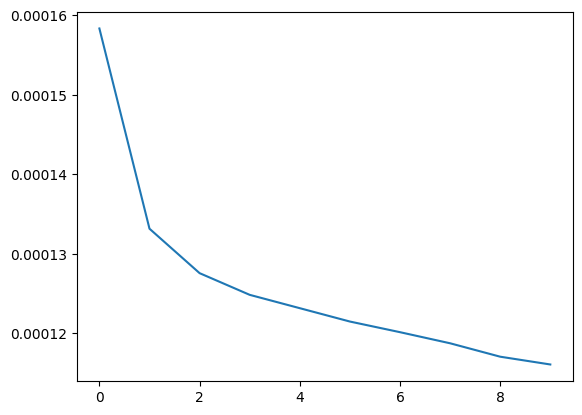

In [12]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

##Saving the model

In [13]:
torch.save(model.state_dict(), 'ncf_model.pth')

##Loading the model

In [ ]:
model = RecSysModel()
model.load_state_dict(torch.load('model.pth'))
model.eval()

##Evaluation Metric: RMSE

In [14]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

with torch.no_grad():
    for i, batched_data in enumerate(test_loader):
        model_output = model(batched_data["users"].to(device), batched_data["movies"].to(device))

        model_output_list.append(model_output.sum().item()/len(batched_data["users"]))
        target_rating = batched_data["ratings"].to(device)
        target_rating_list.append(target_rating.sum().item()/len(batched_data["users"]))
        # print(f"model_output: {model_output}, target_output: {target_rating}")

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rmse: {rms}")

rmse: 0.03308763221395452


Sanity check to test if the output is correlated to target or not

In [15]:
from collections import defaultdict

user_est_true = defaultdict(list)

with torch.no_grad():
    for i, batch_data in enumerate(test_loader):
        users = batch_data["users"]
        movies = batch_data["movies"]
        ratings = batch_data["ratings"]

        model_output = model(users.to(device), movies.to(device))
        for j in range(len(users)):
            user_id = users[j].item()
            movie_id = movies[j].item()
            pred_rating = model_output[j][0].item()
            true_rating = ratings[j].item()

            print(f"{user_id}, {movie_id}, {pred_rating}, {true_rating}")
            user_est_true[user_id].append((movie_id, pred_rating, true_rating))

Streaming output truncated to the last 5000 lines.
3954, 343, 3.1412320137023926, 2
423, 182, 3.7353427410125732, 2
1108, 231, 2.4814460277557373, 2
2871, 1631, 2.8926358222961426, 4
2539, 3481, 4.288309097290039, 5
3271, 1246, 4.740322113037109, 3
2067, 2438, 3.8288605213165283, 4
4021, 1148, 3.602658987045288, 4
4084, 424, 2.920168161392212, 4
689, 1132, 4.527861595153809, 5
3498, 2774, 2.440861463546753, 2
3768, 799, 3.538588762283325, 4
2204, 525, 2.8513991832733154, 2
4456, 83, 3.8295466899871826, 4
3777, 497, 2.5543715953826904, 4
5069, 2274, 4.02045202255249, 4
4060, 3569, 3.7784712314605713, 4
4048, 2218, 2.5058481693267822, 1
2193, 1107, 3.6284899711608887, 3
845, 2855, 3.4702699184417725, 3
654, 460, 2.7650585174560547, 4
2029, 3242, 3.887153148651123, 4
1539, 1199, 4.0391845703125, 4
1811, 1990, 3.8768343925476074, 4
4994, 984, 3.0214078426361084, 3
1118, 1776, 4.343451499938965, 4
5579, 3039, 3.8039824962615967, 3
1313, 2754, 1.7841415405273438, 4
4541, 2845, 3.423629522323

##Evaluation Metric: Precession @ k and Recall @ K

In [16]:
with torch.no_grad():
    precisions = dict()
    recalls = dict()

    k = 20
    threshold = 3.5
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x:x[1], reverse=True)
        n_rel = sum((true_r>=threshold) for (_, _, true_r) in user_ratings)
        n_rec_k = sum((est>=threshold) for (_, est, _) in user_ratings[:k])

        n_rel_and_n_rec_K = sum(((true_r>=threshold) and (est >= threshold)) for (_, est, true_r) in user_ratings[:k])

        print(f"uid {uid}, n_rel {n_rel}, n_rec_k {n_rec_k}, n_rel_and_rec_k {n_rel_and_n_rec_K}")

        precisions[uid] = n_rel_and_n_rec_K / n_rec_k if n_rec_k !=0 else 0

        recalls[uid] = n_rel_and_n_rec_K / n_rel if n_rel !=0 else 0



Streaming output truncated to the last 5000 lines.
uid 2770, n_rel 14, n_rec_k 7, n_rel_and_rec_k 3
uid 272, n_rel 25, n_rec_k 20, n_rel_and_rec_k 12
uid 2579, n_rel 7, n_rec_k 11, n_rel_and_rec_k 4
uid 5566, n_rel 32, n_rec_k 20, n_rel_and_rec_k 12
uid 2728, n_rel 5, n_rec_k 5, n_rel_and_rec_k 5
uid 1121, n_rel 9, n_rec_k 7, n_rel_and_rec_k 4
uid 5570, n_rel 16, n_rec_k 20, n_rel_and_rec_k 15
uid 1903, n_rel 27, n_rec_k 20, n_rel_and_rec_k 19
uid 5452, n_rel 27, n_rec_k 20, n_rel_and_rec_k 13
uid 3872, n_rel 10, n_rec_k 9, n_rel_and_rec_k 7
uid 2053, n_rel 47, n_rec_k 20, n_rel_and_rec_k 18
uid 856, n_rel 16, n_rec_k 19, n_rel_and_rec_k 16
uid 4318, n_rel 6, n_rec_k 6, n_rel_and_rec_k 5
uid 3902, n_rel 15, n_rec_k 9, n_rel_and_rec_k 4
uid 3701, n_rel 9, n_rec_k 5, n_rel_and_rec_k 5
uid 2101, n_rel 30, n_rec_k 7, n_rel_and_rec_k 7
uid 5957, n_rel 15, n_rec_k 18, n_rel_and_rec_k 13
uid 2279, n_rel 17, n_rec_k 16, n_rel_and_rec_k 15
uid 4482, n_rel 11, n_rec_k 13, n_rel_and_rec_k 6
uid 6

In [17]:
print(f"precision @ {k}: {sum(prec for prec in precisions.values()) / len(precisions)}")
print(f"recall @ {k}: {sum(prec for prec in recalls.values()) / len(recalls)}")

precision @ 20: 0.7367791964248953
recall @ 20: 0.6423858844484542


##Getting the actual movie recommedations
(For the users already in the dataset)

In [18]:
movies_file = os.path.join(extract_path, "ml-1m", "movies.dat")
movies_columns = ['MovieID', 'Title', 'Genres']
movies_df = pd.read_csv(movies_file, sep='::', engine='python', header=None, names=movies_columns, encoding = 'latin-1')

In [19]:
top_recommendations = defaultdict(list)
all_movie_ids = set(df.MovieID.values)
print(all_movie_ids)
for user_id, ratings in user_est_true.items():
    sorted_ratings = sorted(ratings, key=lambda x: x[0], reverse=True)

    rated_movie_ids = [movie_id for movie_id,_,_ in sorted_ratings]
    # print(rated_movie_ids)

    unrated_movie_ids = list(all_movie_ids - set(rated_movie_ids))

    user_ids = [user_id] * len(unrated_movie_ids)
    movie_ids = unrated_movie_ids

    user_tensor = torch.tensor(user_ids, dtype=torch.long, device=device)
    movie_tensor = torch.tensor(movie_ids, dtype=torch.long, device=device)
    model_output = model(user_tensor, movie_tensor)

    unrated_ratings = list(zip(model_output.tolist(), unrated_movie_ids))
    unrated_ratings.sort(key=lambda x: x[0][0], reverse=True)

    top_movie_ids = [movie_id for (_, movie_id) in unrated_ratings[:k]]
    top_recommendations[user_id] = top_movie_ids



{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [20]:
# Print the top 5 recommendations for each user along with their favorite movie to check if the recommendations make sense
cnt = 10
for user_id, top_movies in top_recommendations.items():
    cnt-=1
    if cnt>0:

        ratings = user_est_true[user_id]
        sorted_ratings = sorted(ratings, key=lambda x: x[0], reverse=True)
        rated_movie_ids = [movie_id for movie_id,_,true_rating in sorted_ratings if true_rating==5]


        print(f"\nUser ID: {user_id}")

        print(f"\n Liked Movies: ")

        for movie in rated_movie_ids:
            print(f"{movies_df[lbl_movie.inverse_transform([movie])[0]==movies_df['MovieID']]['Title'].values} || {movies_df[lbl_movie.inverse_transform([movie])[0]==movies_df['MovieID']]['Genres'].values}")

        print(f"\n Recommended Movies: ")

        for movie in top_movies[:5]:
            print(f"{movies_df[lbl_movie.inverse_transform([movie])[0]==movies_df['MovieID']]['Title'].values} || {movies_df[lbl_movie.inverse_transform([movie])[0]==movies_df['MovieID']]['Genres'].values}")



User ID: 4830

 Liked Movies: 
['Best in Show (2000)'] || ['Comedy']
['Fabulous Baker Boys, The (1989)'] || ['Drama|Romance']
['Close Encounters of the Third Kind (1977)'] || ['Drama|Sci-Fi']
['Raisin in the Sun, A (1961)'] || ['Drama']
['Insider, The (1999)'] || ['Drama']
['October Sky (1999)'] || ['Drama']
['Shakespeare in Love (1998)'] || ['Comedy|Romance']
['Waking Ned Devine (1998)'] || ['Comedy']
['Rocky (1976)'] || ['Action|Drama']
['Witness (1985)'] || ['Drama|Romance|Thriller']
['This Is Spinal Tap (1984)'] || ['Comedy|Drama|Musical']
['Graduate, The (1967)'] || ['Drama|Romance']
["One Flew Over the Cuckoo's Nest (1975)"] || ['Drama']
['Gone with the Wind (1939)'] || ['Drama|Romance|War']
['Casablanca (1942)'] || ['Drama|Romance|War']

 Recommended Movies: 
['Lamerica (1994)'] || ['Drama']
['Pather Panchali (1955)'] || ['Drama']
['To Kill a Mockingbird (1962)'] || ['Drama']
['Sanjuro (1962)'] || ['Action|Adventure']
['It Happened One Night (1934)'] || ['Comedy']

User ID: 575

##Utility functions for recommending movie to new users

In [66]:
# Calculate entropy for each movie based on historical user ratings
def calculate_entropy(ratings_df):
    movie_entropy = {}
    total_ratings = len(ratings_df)

    for movie_id, group in ratings_df.groupby('MovieID'):
        num_ratings = len(group)
        p = num_ratings / total_ratings
        entropy = -p * np.log2(p)
        movie_entropy[movie_id] = entropy

    return movie_entropy

# Select an initial set of movies with highest entropy
def select_initial_movies(movie_entropy, num_initial_movies):
    movie_popularity = df['MovieID'].value_counts().to_dict()
    high_entropy_movies = sorted(movie_entropy, reverse=True)
    initial_movies = []
    while len(initial_movies)<num_initial_movies:
        movie = high_entropy_movies.pop(0)
        if movie_popularity[movie] > 100:
            initial_movies.append(movie)

    return initial_movies

# Calculate information gain for each movie based on user ratings
def calculate_information_gain(user_ratings, movie_entropy):
    information_gain = {}

    for movie_id, rating in user_ratings.items():
        gain = movie_entropy[movie_id] * (5 - abs(rating - 3))
        information_gain[movie_id] = gain

    return information_gain

def update_embeddings(model, optimizer, new_user_data):
    new_user_ids = max(df.UserID)+1
    new_movie_ids = torch.tensor(new_user_data["movies"], dtype=torch.long, device=device)
    new_ratings = torch.tensor(new_user_data["ratings"], dtype=torch.long, device=device)
    print(new_user_ids)
    new_user_embedding = torch.zeros(1, 128, device=device)
    new_user_embeds = torch.cat([model.user_embed.weight, new_user_embedding])

    new_user_ids = [new_user_ids] * len(new_movie_ids)

    new_user_tensor = torch.tensor(new_user_ids, dtype=torch.long, device=device)

    # Update embeddings for rated movies
    model.train()
    optimizer.zero_grad()
    output = model(new_user_tensor, new_movie_ids)
    loss = loss_func(output, new_ratings)
    print(loss)
    loss.backward()
    optimizer.step()

    # Update user embeddings matrix
    model.user_embed = nn.Embedding.from_pretrained(new_user_embeds)

def recommend_movies(model, userid, user_data):
    top_k = 20
    top_recommendations = []
    all_movie_ids = set(df.MovieID.values)

    rated_movie_ids = list(user_data["movies"].numpy())
    # print(rated_movie_ids)

    unrated_movie_ids = list(all_movie_ids - set(rated_movie_ids))

    user_ids = [user_id] * len(unrated_movie_ids)
    movie_ids = unrated_movie_ids

    user_tensor = torch.tensor(user_ids, dtype=torch.long, device=device)
    movie_tensor = torch.tensor(movie_ids, dtype=torch.long, device=device)
    model_output = model(user_tensor, movie_tensor)

    unrated_ratings = list(zip(model_output.tolist(), unrated_movie_ids))
    unrated_ratings.sort(key=lambda x: x[0][0], reverse=True)

    top_movie_ids = [movie_id for (_, movie_id) in unrated_ratings[:top_k]]

    return top_movie_ids




## Rating and Recommendation
Asking new user to rate movies with high entropy (using information theory) to get best new user embeddings and using this embeddings to get recommendations



In [ ]:

# Main loop for user interaction
def main():
    new_user_ratings = {}

    movie_entropy = calculate_entropy(df)

    num_initial_movies = 2
    initial_movies = select_initial_movies(movie_entropy, num_initial_movies)
    print(initial_movies)
    print("Please rate the following movies:")
    print("Skip a particular movie by entering -1")
    for movie_id in initial_movies:
        movie_title = movies_df[movies_df['MovieID'] == lbl_movie.inverse_transform([movie_id])[0]]['Title'].values[0]
        user_rating = int(input(f"Rate '{movie_title}': "))
        if user_rating!=-1:
            new_user_ratings[movie_id] = user_rating

    information_gain = calculate_information_gain(new_user_ratings, movie_entropy)

    num_adaptive_movies = 5
    adaptive_movies = sorted(information_gain, key=information_gain.get, reverse=True)[:num_adaptive_movies]

    new_user_data = {
        "movies": list(new_user_ratings.keys()),
        "ratings": list(new_user_ratings.values())
    }

    new_user_id = len(df.UserID)
    update_embeddings(model, optimizer, new_user_data)

    recommendations = recommend_movies(model, new_user_id, new_user_data)

    print("Top Recommendations:")
    for movie_id in recommendations:
        movie_title = movies_df[movies_df['MovieID'] == movie_id]['Title'].values[0]
        print(movie_title)

if __name__ == "__main__":
    main()